Install & Import

In [44]:
!pip install torch torchvision matplotlib

In [46]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

Define Path

In [48]:
data_dir = r"D:\AFC\Cat vs Dog\datasets\datasets"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

BATCH_SIZE = 32
IMG_SIZE = 128

Transforms and Dataset Prep

In [49]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


Load Dataset

In [52]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.image_paths = sorted([os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        img_id = os.path.basename(img_path)
        return img, img_id

test_dataset = TestDataset(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Visualize Sample

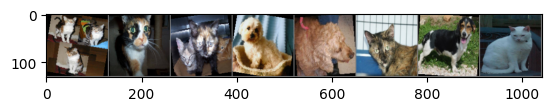

Labels: [0, 0, 0, 1, 1, 0, 1, 0]


In [53]:
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print("Labels:", labels[:8].tolist())

ResNet18

In [55]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)


for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("ResNet18 with updated weights loaded successfully.")

ResNet18 with updated weights loaded successfully.


Model Training

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {running_loss:.3f} - Train Acc: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"           -> Val Loss: {val_loss:.3f} - Val Acc: {val_acc:.2f}%\\n")

Epoch [1/5] - Train Loss: 174.564 - Train Acc: 87.61%
           -> Val Loss: 29.125 - Val Acc: 92.16%\n
Epoch [2/5] - Train Loss: 151.677 - Train Acc: 89.17%
           -> Val Loss: 27.689 - Val Acc: 92.68%\n
Epoch [3/5] - Train Loss: 154.582 - Train Acc: 89.22%
           -> Val Loss: 28.118 - Val Acc: 92.20%\n
Epoch [4/5] - Train Loss: 148.440 - Train Acc: 89.53%
           -> Val Loss: 27.445 - Val Acc: 92.54%\n
Epoch [5/5] - Train Loss: 147.823 - Train Acc: 89.75%
           -> Val Loss: 28.173 - Val Acc: 92.16%\n


Predictions 

In [57]:
model.eval()
predictions = []

with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for img_id, label in zip(image_ids, predicted.cpu().numpy()):
            predictions.append({'id': img_id, 'label': int(label)})

submission_df = pd.DataFrame(predictions)
submission_df = submission_df.sort_values(by="id")
submission_df.to_csv("submission.csv", index=False)

print("submission.csv file created!")
submission_df.head()


submission.csv file created!


,id,label
0,1.jpg,0
1,10.jpg,1
2,100.jpg,0
3,101.jpg,0
4,102.jpg,1


Visualizing Predictions

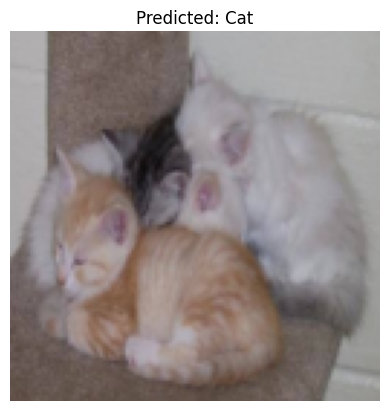

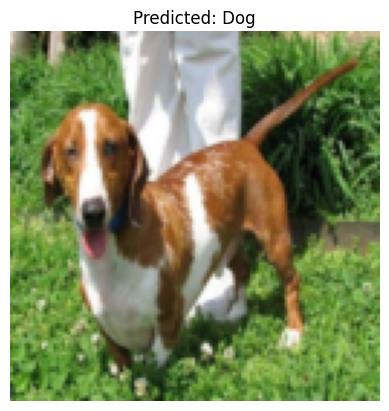

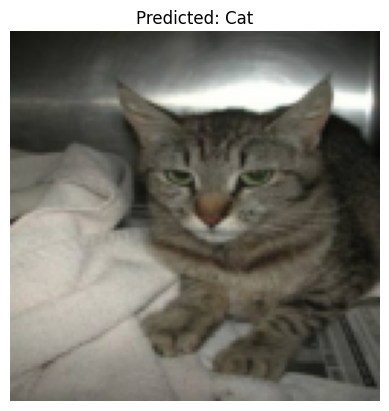

In [58]:
model.eval()

for images, image_ids in test_loader:
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

    for i in range(3):  # Show 3 predictions
        img = images[i] / 2 + 0.5
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.title(f"Predicted: {'Dog' if preds[i]==1 else 'Cat'}")
        plt.axis('off')
        plt.show()
    break